<a href="https://colab.research.google.com/github/AlexeyTri/PyTorchTutorials/blob/main/Tutorial12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer learning**

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [12]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# transform data

In [13]:
mean = np.array([0.5,0.5,0.5])
std = np.array([0.25,0.25,0.25])

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])
}

# data

In [15]:
data_dir = '/gdrive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_names

['ants', 'bees']

In [16]:
def imshow(inp, title):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

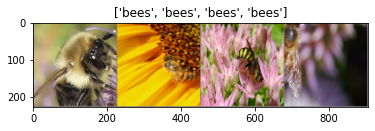

In [17]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# trainig function

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # itarete over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward. track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time()  - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# fine tuning

* load a pratrained model and reset final fully connected layer

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# here the size of each output sample is set to 2
# alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
model.fc = nn.Linear(num_ftrs, 2)

In [21]:
model.to(device)
criterion = nn.CrossEntropyLoss()
# observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [24]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6088 Acc: 0.6885
val Loss: 0.3805 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5265 Acc: 0.7746
val Loss: 0.3126 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4212 Acc: 0.8402
val Loss: 0.2569 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4123 Acc: 0.7951
val Loss: 0.2418 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4149 Acc: 0.8197
val Loss: 0.2202 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3950 Acc: 0.8197
val Loss: 0.2054 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3795 Acc: 0.8361
val Loss: 0.2093 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4090 Acc: 0.7992
val Loss: 0.2147 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3977 Acc: 0.8279
val Loss: 0.2081 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3896 Acc: 0.8402
val Loss: 0.2279 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3410 Acc: 0.8566
val Loss: 0.1974 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3753 Acc: 0.8197
val Loss: 0.2030 Acc: 0.9216

Ep

# ConvNet as fixed feature extractor

* Here, we need to freeze all the network except the final layer.
*  We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# parameters of newly constractes modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [27]:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

In [29]:
# observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv =  train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6538 Acc: 0.6926
val Loss: 0.3698 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5963 Acc: 0.7254
val Loss: 0.2586 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4613 Acc: 0.7910
val Loss: 0.2368 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.6097 Acc: 0.7541
val Loss: 0.2164 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.6978 Acc: 0.7623
val Loss: 0.2396 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4373 Acc: 0.8033
val Loss: 0.2005 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4295 Acc: 0.8443
val Loss: 0.1953 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3536 Acc: 0.8566
val Loss: 0.2175 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2910 Acc: 0.8811
val Loss: 0.1999 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3302 Acc: 0.8361
val Loss: 0.2237 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4722 Acc: 0.8033
val Loss: 0.2681 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3018 Acc: 0.8770
val Loss: 0.2025 Acc: 0.9412

Ep